# Load Dependencies

In [ ]:
!pip install geopandas rasterio rasterstats

     |████████████████████████████████| 1.0MB 27.8MB/s 
     |████████████████████████████████| 19.3MB 57.1MB/s 
     |████████████████████████████████| 6.6MB 33.4MB/s 
     |████████████████████████████████| 15.4MB 202kB/s 
     |████████████████████████████████| 133kB 45.8MB/s 


In [ ]:
import os
import pickle
import ee

import gdal
import time
import pandas as pd
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterstats
import folium
import tensorflow as tf
import seaborn as sns

from matplotlib import cm
from matplotlib import colors
from rasterio.plot import show

from google.colab import drive

from rasterio.features import rasterize
from rasterstats.io import bounds_window

from sklearn.metrics import (classification_report, confusion_matrix, 
                             f1_score, accuracy_score)
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     KFold, cross_val_score)
from sklearn.ensemble import (RandomForestClassifier, 
                              ExtraTreesClassifier, 
                              BaggingClassifier,
                              AdaBoostClassifier)
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from scipy.stats import sem
from matplotlib import pyplot 
from xgboost import XGBClassifier

# Authentication

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=7W-V7X2HASkaVLArWw3rCzzAHk4CY__1rvouaz254cY&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWg56CGcBIjsEntu6aPv7Bnbqs9odxrWC1Lrf3msSHDctH6-yKRp9yc

Successfully saved authorization token.


# File Path

In [ ]:
# path for training polygon
asset = "/content/drive/MyDrive/Earth Engine Asset"

# path for folder to save file
data = "/content/drive/MyDrive/Data"

In [ ]:
# sen_10 for Sentinel 2 Image with original resolution
# sen_30 for Sentinel 2 Image rescaled to 30m
# lan for Landsat 8 Image
path_sen_10 = os.path.join(data, 'Nganjuk_Sentinel_10_clipped')
path_sen_30 = os.path.join(data, 'Nganjuk_Sentinel_30_clipped')
path_lan = os.path.join(data, 'Nganjuk_Landsat_clipped')

raster_sen_10 = ".".join([path_sen_10, "tif"])
raster_sen_30 = ".".join([path_sen_30, "tif"])
raster_lan = ".".join([path_lan, "tif"])

In [ ]:
# file where the prediction result will be saved
output_image_sen_10 = os.path.join(
    data,'dnn_classification_sentinel_10_clipped.tif')

# Load Sample Area

In [ ]:
# path to training polygon
sentinel_asset = os.path.join(
    asset, 'ML_classification_repo_sentinel_sample_MkIV.geojson')
landsat_asset = os.path.join(
    asset, 'ML_classification_repo_landsat_sample_MkIV.geojson')

def get_center(path):
    training_vectors = gpd.read_file(path)
    bbox = training_vectors.total_bounds
    center = shp.geometry.box(bbox[0], bbox[1], bbox[2], bbox[3]).centroid

    return training_vectors, center

training_sen, center_sen = get_center(sentinel_asset)
training_lan, center_land = get_center(landsat_asset)

# Search Satellite Imageries

In [ ]:
# area of interest
region = ee.FeatureCollection('users/devatrisa/nganjuk-polygon')
region = region.geometry()

# band that will be used
band_sen = ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')
band_lan = ('B2', 'B3', 'B4', 'B5', 'B6', 'B7')

# filter image according to date and area of interest
sen = ee.ImageCollection(ee.ImageCollection('COPERNICUS/S2_SR')
                         .filterDate('2020-03-10', '2020-03-15')
                         .filterBounds(region)
                         .select(band_sen))
lan = ee.ImageCollection(ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
                         .filterDate('2020-03-10', '2020-03-20')
                         .filterBounds(region)
                         .select(band_lan))

image_sen = sen.mean().rename(band_sen).clip(region)
image_lan = lan.mean().rename(band_lan).clip(region)

# Visualize

In [ ]:
#list of basemap link
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = ('https://server.arcgisonline.com/ArcGIS/rest/services/'
                 'World_Imagery/MapServer/tile/{z}/{y}/{x}'),
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

In [ ]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    map_vis = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    # basemap used
    basemaps['Google Maps'].add_to(map_vis)
    basemaps['Google Satellite Hybrid'].add_to(map_vis)
    for k,v in dicc.items():
      # check file type before adding to map
      if gpd.geodataframe.GeoDataFrame == type(v):
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(map_vis) 
      elif ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(map_vis)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(map_vis)
    map_vis.add_child(folium.LayerControl())
    return map_vis

In [ ]:
# satellite images display parameter
vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 3000,
  'gamma': 1.25 # gamma boosting 125%
}

# center for location shown by the map
Mapdisplay(center=[center_sen.y, center_sen.x],
           dicc={'S2':sen.mean().clip(region).getMapId(vis_params),
                 'Sentinel Training Data':training_sen,
                 'L8':lan.mean().clip(region).getMapId(vis_params),
                 'Landsat Training Data':training_lan}, 
           zoom_start=12)

# Save Image to Google Drive

In [ ]:
# Export the image, specifying scale and region.
task_sen_30 = ee.batch.Export.image.toDrive(**{
    'image': image_sen,
    'description': 'Nganjuk_Sentinel_03-15-2020_gamma:1.25',
    'folder': 'Data',
    'fileNamePrefix': 'Nganjuk_Sentinel_30_mini_boosted',
    'scale': 30,
    'region': region,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

task_sen_10 = ee.batch.Export.image.toDrive(**{
    'image': image_sen,
    'description': 'Nganjuk_Sentinel_03-15-2020_gamma:1.25',
    'folder': 'Data',
    'fileNamePrefix': 'Nganjuk_Sentinel_10_mini_boosted',
    'scale': 10,
    'region': region,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

task_lan = ee.batch.Export.image.toDrive(**{
    'image': image_lan,
    'description': 'Nganjuk_Landsat_03-20-2020_gamma:1.25',
    'folder': 'Data',
    'fileNamePrefix': 'Nganjuk_Landsat_mini_boosted',
    'scale': 30,
    'region': region,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

The following script will check whether the image already existed. If not, it will export the image and display the progress evey 15 seconds.

In [ ]:
if os.path.exists(raster_sen_10):
    pass
else:
    task_sen_10.start()
    while task_sen_10.active():
      print('Polling for task (id: {}).'.format(task_sen_10.id))
      time.sleep(15)

if os.path.exists(raster_sen_30):
    pass
else:
    task_sen_30.start()
    while task_sen_30.active():
      print('Polling for task (id: {}).'.format(task_sen_30.id))
      time.sleep(15)

if os.path.exists(raster_lan):
    pass
else:
    task_lan.start()
    while task_lan.active():
      print('Polling for task (id: {}).'.format(task_lan.id))
      time.sleep(15)

# Convert Sample Area to Array

Create a function that convert image inside training polygon into array. Inner bound means that only pixel with all corner inside the polygon are taken. Outer bound means that as long as the centroids are inside the polygon, it will be taken.

In [ ]:
def all_values(x):
    return x

def get_raw(raster_file, training_vectors):
    X_raw = []
    y_raw = []
    with rasterio.open(raster_file, 'r') as src:
        for (label, geom) in zip(training_vectors['class'], 
                                 training_vectors['geometry']):
            window = bounds_window(geom.bounds, src.transform)
            window_affine = src.window_transform(window)
            fsrc = src.read(window=window)
            
            # create mask of sample area 
            mask = rasterize(
                [(geom, 1)],
                out_shape=fsrc.shape[1:],
                transform=window_affine,
                fill=0,
                dtype='uint8',
                # True for inner bound, False for outer bound
                all_touched=True
            ).astype(bool)
            
            label_pixels = np.argwhere(mask)
        
            for (row, col) in label_pixels:
                data = fsrc[:,row,col]
                one_x = np.nan_to_num(data, nan=1e-3)
                X_raw.append(one_x)
                y_raw.append(label)
    
    return X_raw, y_raw

In [ ]:
X_raw_sen_30, y_raw_sen_30 = get_raw(raster_sen_30, training_sen)
X_raw_sen_10, y_raw_sen_10 = get_raw(raster_sen_10, training_sen)
X_raw_lan, y_raw_lan = get_raw(raster_lan, training_lan)

In [ ]:
X_sen_30 = np.array(X_raw_sen_30)
y_sen_30_temp = np.array(y_raw_sen_30)
X_sen_10 = np.array(X_raw_sen_10)
y_sen_10_temp = np.array(y_raw_sen_10)
X_lan = np.array(X_raw_lan)
y_lan_temp = np.array(y_raw_lan)
(X_sen_30.shape, y_sen_30_temp.shape,
 X_sen_10.shape, y_sen_10_temp.shape,
 X_lan.shape, y_lan_temp.shape)

((12972, 6), (12972,), (88755, 6), (88755,), (12704, 6), (12704,))

Count the number of pixel on each Class

In [ ]:
sen_10_unique, sen_10_counts = np.unique(y_sen_10_temp, return_counts=True)
print(dict(zip(sen_10_unique, sen_10_counts)))

sen_30_unique, sen_30_counts = np.unique(y_sen_30_temp, return_counts=True)
print(dict(zip(sen_30_unique, sen_30_counts)))

lan_unique, lan_counts = np.unique(y_lan_temp, return_counts=True)
print(dict(zip(lan_unique, lan_counts)))

{0: 16276, 1: 4904, 2: 13364, 3: 18335, 4: 17891, 5: 3138, 6: 14847}
{0: 2663, 1: 825, 2: 1826, 3: 2653, 4: 2302, 5: 796, 6: 1907}
{0: 2663, 1: 825, 2: 1826, 3: 2653, 4: 2302, 5: 796, 6: 1639}


Encode the label

In [ ]:
y_sen_10 = to_categorical(y_sen_10_temp)
y_sen_30 = to_categorical(y_sen_30_temp)
y_lan = to_categorical(y_lan_temp)

Add Composite Index

In [ ]:
def normalized_difference(arr, a, b):
    nd = (np.expand_dims((arr[..., a] - arr[..., b]) / 
                                            (arr[..., a] + arr[..., b]), 
                                            axis=1))

    return nd

def get_evi(arr, nir, red, blue):
    evi = (np.expand_dims(2.5 * (arr[..., nir] - arr[..., red]) / 
                          (arr[..., nir] + 6 * arr[..., red] - 
                           7.5 * arr[..., blue] +1), axis=1))
    
    return evi

def get_evi2(arr, nir, red):
    evi2 = (np.expand_dims(2.5 * (arr[..., nir] - arr[..., red]) / 
                          (arr[..., nir] + 2.4 * arr[..., red] 
                           +1), axis=1))
    
    return evi2

def get_bsi(arr, swir, nir, red, green):
    bsi = (np.expand_dims(2.5 * ((arr[..., swir] + arr[..., red]) - 
                                 (arr[..., nir] + arr[..., green])) / 
                          ((arr[..., swir] + arr[..., red]) + 
                           (arr[..., nir] + arr[..., green])), axis=1))
    
    return bsi

In [ ]:
ndvi_sen_30 = normalized_difference(X_sen_30, 3, 2)
ndwi_sen_30 = normalized_difference(X_sen_30, 1, 3)
ndbi_sen_30 = normalized_difference(X_sen_30, 4, 3)
ndti_sen_30 = normalized_difference(X_sen_30, 4, 5)
evi_sen_30 = get_evi2(X_sen_30, 3, 2)
bsi_sen_30 = get_bsi(X_sen_30, 4, 3, 2, 1)

ndvi_sen_10 = normalized_difference(X_sen_10, 3, 2)
ndwi_sen_10 = normalized_difference(X_sen_10, 1, 3)
ndbi_sen_10 = normalized_difference(X_sen_10, 4, 3)
ndti_sen_10 = normalized_difference(X_sen_10, 4, 5)
evi_sen_10 = get_evi2(X_sen_10, 3, 2)
bsi_sen_10 = get_bsi(X_sen_10, 4, 3, 2, 1)

ndvi_lan = normalized_difference(X_lan, 3, 2)
ndwi_lan = normalized_difference(X_lan, 1, 3)
ndbi_lan = normalized_difference(X_lan, 4, 3)
ndti_lan = normalized_difference(X_lan, 4, 5)
evi_lan = get_evi2(X_lan, 3, 2)
bsi_lan = get_bsi(X_lan, 4, 3, 2, 1)

X_sen_30 = np.concatenate([X_sen_30, ndvi_sen_30, ndwi_sen_30, ndbi_sen_30, 
                           ndti_sen_30, evi_sen_30, bsi_sen_30], axis=1)
X_sen_10 = np.concatenate([X_sen_10, ndvi_sen_10, ndwi_sen_10, ndbi_sen_10, 
                           ndti_sen_10, evi_sen_10, bsi_sen_10], axis=1)
X_lan = np.concatenate([X_lan, ndvi_lan, ndwi_lan, ndbi_lan, ndti_lan, 
                        evi_lan, bsi_lan], axis=1)

X_sen_10.shape, X_sen_30.shape, X_lan.shape

((88755, 12), (12972, 12), (12704, 12))

# Define Model

## Random Forest

In [ ]:
model_rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=1,
    min_samples_split=2,
    class_weight='balanced',
    max_samples=0.3,
    n_jobs=-1,
    verbose=1,
    random_state=0)

## Decision Tree

### Without Bagging

In [ ]:
model_dt = DecisionTreeClassifier(
    class_weight='balanced',
    criterion='gini',
    max_depth=10, 
    max_features=None, 
    min_samples_leaf=1, 
    min_samples_split=2,
)

### With Bagging

In [ ]:
model_bag = BaggingClassifier(
    DecisionTreeClassifier(
        class_weight='balanced',
        criterion='entropy',
        max_depth=None,
        max_features=None,
        min_samples_leaf=1,
        min_samples_split=2
    ),
    bootstrap=True, 
    max_features=1.0,
    max_samples=0.3, 
    n_estimators=100, 
    n_jobs=-1
)

## Extra Trees

In [ ]:
model_et = ExtraTreesClassifier(
    bootstrap=True, 
    class_weight='balanced',
    criterion='gini', 
    max_features='auto',
    max_samples=0.3,
    min_samples_leaf=1, 
    min_samples_split=5,
    n_estimators=100, n_jobs=-1,                     
)

## Logistic Regression

In [ ]:
model_lr = LogisticRegression(
    C=100000.0, 
    class_weight='balanced', 
    fit_intercept=True, 
    intercept_scaling=1, 
    max_iter=200, 
    multi_class='auto', 
    penalty='l1',
    solver='liblinear', 
    tol=0.0001)

## Linear Support Vector Machine 

In [ ]:
model_sv=LinearSVC(
    C=0.1,
    class_weight='balanced',
    loss='hinge',
    max_iter=1000,
    penalty='l2')

## AdaBoost 

In [ ]:
model_ab = AdaBoostClassifier(
    DecisionTreeClassifier(
        criterion='gini',
        splitter='best',
        min_samples_leaf=1,
        min_samples_split=2,
        max_features='auto',
        class_weight='balanced',
        max_depth=10
    ),
    n_estimators=100,
    algorithm='SAMME.R',
    learning_rate=1.0
)

## XGBoost

### Tree Booster

In [ ]:
model_tb=XGBClassifier(
    booster='gbtree',
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

### Linear Booster

In [ ]:
model_lb=XGBClassifier(
    booster='gblinear',
    reg_lambda=1,
    updater='coord_descent',
    feature_selector='shuffle'
)

# Model Evaluation

k-fold cross validation, k=n_splits

In [ ]:
def evaluate(X, y, model):
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(model, X, y, scoring='f1_weighted', 
                             cv=cv, n_jobs=-1, verbose=1)
    print('F1: %.4f, Std: %.4f, Se: %.4f' % (np.mean(scores), 
                                             np.std(scores), sem(scores)))

## Random Forest

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_rf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9704, Std: 0.0023, Se: 0.0008


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.0min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_rf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9306, Std: 0.0049, Se: 0.0016


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   23.1s finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_rf)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9310, Std: 0.0059, Se: 0.0020


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.3s finished


## Decision Tree

### Without Bagging

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_dt)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9509, Std: 0.0033, Se: 0.0011


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.1s finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_dt)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9019, Std: 0.0084, Se: 0.0028


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_dt)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9035, Std: 0.0076, Se: 0.0025


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


### With Bagging

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_bag)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9717, Std: 0.0020, Se: 0.0007


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.7min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_bag)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9308, Std: 0.0059, Se: 0.0020


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_bag)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9312, Std: 0.0057, Se: 0.0019


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


## Extra Trees

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_et)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9675, Std: 0.0022, Se: 0.0007


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_et)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9273, Std: 0.0049, Se: 0.0016


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.7s finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_et)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9273, Std: 0.0071, Se: 0.0024


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.3s finished


## Logistic Regression

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_lr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9412, Std: 0.0027, Se: 0.0009


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 43.3min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_lr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9167, Std: 0.0047, Se: 0.0016


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.3min finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_lr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9193, Std: 0.0065, Se: 0.0022


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.1min finished


## Linear Support Vector Machine

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_sv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.7359, Std: 0.0998, Se: 0.0333


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  9.6min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_sv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.7538, Std: 0.0492, Se: 0.0164


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   41.0s finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_sv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.6989, Std: 0.1310, Se: 0.0437


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.5s finished


## AdaBoost

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_ab)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9662, Std: 0.0021, Se: 0.0007


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.4min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_ab)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9349, Std: 0.0047, Se: 0.0016


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   37.8s finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_ab)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9336, Std: 0.0069, Se: 0.0023


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   35.6s finished


## XGBoost

### Tree Booster

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_tb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9584, Std: 0.0021, Se: 0.0007


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  5.5min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_tb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9250, Std: 0.0046, Se: 0.0015


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   58.4s finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_tb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.9233, Std: 0.0075, Se: 0.0025


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   56.4s finished


### Linear Booster

In [ ]:
evaluate(X_sen_10, y_sen_10_temp, model_lb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.6728, Std: 0.0065, Se: 0.0022


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.4min finished


In [ ]:
evaluate(X_sen_30, y_sen_30_temp, model_lb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.6218, Std: 0.0159, Se: 0.0053


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.9s finished


In [ ]:
evaluate(X_lan, y_lan_temp, model_lb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


F1: 0.6413, Std: 0.0131, Se: 0.0044


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.1s finished


# Deep Learning

Reshape the array

In [ ]:
X_sen_10_n = X_sen_10.reshape(X_sen_10.shape[0], 1, X_sen_10.shape[1])
X_sen_30_n = X_sen_30.reshape(X_sen_30.shape[0], 1, X_sen_30.shape[1])
X_lan_n = X_lan.reshape((X_lan.shape[0], 1, X_lan.shape[1]))

In [ ]:
METRICS = [
      keras.metrics.Precision(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall')
]

In [ ]:
def get_model_dense(input_data, metrics=METRICS):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=input_data.shape[1:]),
        keras.layers.Dense(14, activation='relu'),
        keras.layers.Dense(7, activation='softmax')
    ])

    model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=metrics)

    return model

In [ ]:
def get_cnn(input_data, metrics=METRICS):
    model = keras.Sequential([
        keras.layers.InputLayer(input_data.shape[1:]),
        keras.layers.Conv1D(filters=32, kernel_size=1, 
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Conv1D(filters=32, kernel_size=1, 
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Conv1D(filters=64, kernel_size=1, 
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Conv1D(filters=64, kernel_size=1, 
                            activation="relu", padding="valid"),
        keras.layers.MaxPooling1D(1),
        keras.layers.Flatten(),
        keras.layers.Dense(120, activation="relu"),
        keras.layers.Dense(160, activation="relu"),
        keras.layers.Dense(7, activation="softmax")
    ])

    model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=metrics)

    return model

In [ ]:
def evaluate_model(MODEL, trainX, trainy, testX, testy):
	# encode targets
	trainy_enc = to_categorical(trainy)
	testy_enc = to_categorical(testy)
	# define model
	model = MODEL
	# fit model
	model.fit(trainX, trainy_enc, epochs=100, batch_size=64, verbose=1)
	# evaluate the model
	_, acc, pre, rec = model.evaluate(testX, testy_enc, 
                                   batch_size=64, verbose=1)
	return model, acc, pre, rec

## Cross Validation

### CNN

In [ ]:
X = X_sen_10_n
y = y_sen_10_temp
n_folds = 10
kfold = KFold(n_folds, True, 1)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_cnn(input_data=X), 
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc, 
          'precision : >%.3f' % pre, 
          ' recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/100
1249/1249 [==============================] - 6s 3ms/step - loss: 0.7402 - accuracy: 0.8602 - precision: 0.8602 - recall: 0.8456
Epoch 2/100
1249/1249 [==============================] - 4s 3ms/step - loss: 0.2758 - accuracy: 0.9178 - precision: 0.9178 - recall: 0.9008
Epoch 3/100
1249/1249 [==============================] - 4s 3ms/step - loss: 0.2310 - accuracy: 0.9317 - precision: 0.9317 - recall: 0.9153
Epoch 4/100
1249/1249 [==============================] - 4s 3ms/step - loss: 0.2121 - accuracy: 0.9384 - precision: 0.9384 - recall: 0.9223
Epoch 5/100
1249/1249 [==============================] - 4s 3ms/step - loss: 0.1950 - accuracy: 0.9440 - precision: 0.9440 - recall: 0.9294
Epoch 6/100
1249/1249 [==============================] - 4s 3ms/step - loss: 0.1790 - accuracy: 0.9481 - precision: 0.9481 - recall: 0.9357
Epoch 7/100
1249/1249 [==============================] - 5s 4ms/step - loss: 0.1680 - accuracy: 0.9507 - precision: 0.9507 - recall: 0.9392
Epoch 8/100
1249/124

In [ ]:
df_sen_10_cv = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_sen_10_cv['f1'] = (2*(df_sen_10_cv['precision']*df_sen_10_cv['recall'])/
                      (df_sen_10_cv['precision']+df_sen_10_cv['recall']))
df_sen_10_cv

,accuracy,precision,recall,f1
0,0.961129,0.961129,0.955498,0.958305
1,0.971775,0.971775,0.965863,0.968810
2,0.971665,0.971665,0.965863,0.968755
3,0.970585,0.970585,0.966539,0.968558
4,0.969508,0.969508,0.963610,0.966550
5,0.970349,0.970349,0.966084,0.968212
6,0.970082,0.970082,0.964507,0.967286
7,0.966780,0.966780,0.960789,0.963775
8,0.963566,0.963566,0.959549,0.961554
9,0.971299,0.971299,0.968563,0.969929


In [ ]:
print('accuracy : %.4f' % np.mean(df_sen_10_cv['accuracy']), 
      'precision : %.4f' % np.mean(df_sen_10_cv['precision']), 
      '; recall : %.4f' % np.mean(df_sen_10_cv['recall']),
      '; f1-score : %.4f' % np.mean(df_sen_10_cv['f1']))

accuracy : 0.9687 precision : 0.9687 ; recall : 0.9637 ; f1-score : 0.9662


In [ ]:
X = X_sen_30_n
y = y_sen_30_temp
n_folds = 10
kfold = KFold(n_folds, True, 1)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_cnn(input_data=X), 
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc, 
          'precision : >%.3f' % pre, 
          ' recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/100
183/183 [==============================] - 3s 3ms/step - loss: 3.3237 - accuracy: 0.8498 - precision: 0.8498 - recall: 0.8399
Epoch 2/100
183/183 [==============================] - 1s 3ms/step - loss: 0.6321 - accuracy: 0.8535 - precision: 0.8535 - recall: 0.8301
Epoch 3/100
183/183 [==============================] - 1s 3ms/step - loss: 0.5353 - accuracy: 0.8750 - precision: 0.8750 - recall: 0.8507
Epoch 4/100
183/183 [==============================] - 1s 3ms/step - loss: 0.4922 - accuracy: 0.8753 - precision: 0.8753 - recall: 0.8469
Epoch 5/100
183/183 [==============================] - 1s 3ms/step - loss: 0.4090 - accuracy: 0.8940 - precision: 0.8940 - recall: 0.8612
Epoch 6/100
183/183 [==============================] - 1s 3ms/step - loss: 0.4483 - accuracy: 0.8876 - precision: 0.8876 - recall: 0.8552
Epoch 7/100
183/183 [==============================] - 1s 3ms/step - loss: 0.3772 - accuracy: 0.8987 - precision: 0.8987 - recall: 0.8623
Epoch 8/100
183/183 [=============

In [ ]:
df_sen_30_cv = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_sen_30_cv['f1'] = (2*(df_sen_30_cv['precision']*df_sen_30_cv['recall'])/
                      (df_sen_30_cv['precision']+df_sen_30_cv['recall']))
df_sen_30_cv

,accuracy,precision,recall,f1
0,0.937500,0.937500,0.924499,0.930954
1,0.941176,0.941176,0.924499,0.932763
2,0.914173,0.914173,0.895143,0.904558
3,0.938233,0.938233,0.925212,0.931677
4,0.942610,0.942610,0.924441,0.933437
5,0.942745,0.942745,0.926754,0.934681
6,0.949527,0.949527,0.928296,0.938791
7,0.941083,0.941083,0.911334,0.925969
8,0.934594,0.934594,0.914418,0.924396
9,0.931925,0.931925,0.918273,0.925049


In [ ]:
print('accuracy : %.4f' % np.mean(df_sen_30_cv['accuracy']), 
      'precision : %.4f' % np.mean(df_sen_30_cv['precision']), 
      '; recall : %.4f' % np.mean(df_sen_30_cv['recall']),
      '; f1-score : %.4f' % np.mean(df_sen_30_cv['f1']))

accuracy : 0.9374 precision : 0.9374 ; recall : 0.9193 ; f1-score : 0.9282


In [ ]:
X = X_lan_n
y = y_lan_temp
n_folds = 10
kfold = KFold(n_folds, True, 1)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_cnn(input_data=X), 
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc, 
          'precision : >%.3f' % pre, 
          ' recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/100
179/179 [==============================] - 2s 3ms/step - loss: 4.4392 - accuracy: 0.7659 - precision: 0.7659 - recall: 0.7560
Epoch 2/100
179/179 [==============================] - 1s 3ms/step - loss: 0.8710 - accuracy: 0.8543 - precision: 0.8543 - recall: 0.8381
Epoch 3/100
179/179 [==============================] - 1s 3ms/step - loss: 0.5700 - accuracy: 0.8829 - precision: 0.8829 - recall: 0.8608
Epoch 4/100
179/179 [==============================] - 1s 3ms/step - loss: 0.3982 - accuracy: 0.9073 - precision: 0.9073 - recall: 0.8778
Epoch 5/100
179/179 [==============================] - 1s 3ms/step - loss: 0.3953 - accuracy: 0.9049 - precision: 0.9049 - recall: 0.8773
Epoch 6/100
179/179 [==============================] - 1s 3ms/step - loss: 0.3525 - accuracy: 0.9177 - precision: 0.9177 - recall: 0.8838
Epoch 7/100
179/179 [==============================] - 1s 3ms/step - loss: 0.3766 - accuracy: 0.9084 - precision: 0.9084 - recall: 0.8757
Epoch 8/100
179/179 [=============

In [ ]:
df_lan_cv = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_lan_cv['f1'] = (2*(df_lan_cv['precision']*df_lan_cv['recall'])/
                   (df_lan_cv['precision']+df_lan_cv['recall']))
df_lan_cv

,accuracy,precision,recall,f1
0,0.948553,0.948553,0.928403,0.938370
1,0.935200,0.935200,0.919748,0.927410
2,0.946443,0.946443,0.931550,0.938937
3,0.948345,0.948345,0.924469,0.936255
4,0.926045,0.926045,0.907087,0.916468
5,0.940843,0.940843,0.914173,0.927316
6,0.946656,0.946656,0.936220,0.941409
7,0.949470,0.949470,0.917323,0.933120
8,0.937799,0.937799,0.925984,0.931854
9,0.937002,0.937002,0.925197,0.931062


In [ ]:
print('accuracy : %.4f' % np.mean(df_lan_cv['accuracy']), 
      'precision : %.4f' % np.mean(df_lan_cv['precision']), 
      '; recall : %.4f' % np.mean(df_lan_cv['recall']),
      '; f1-score : %.4f' % np.mean(df_lan_cv['f1']))

accuracy : 0.9416 precision : 0.9416 ; recall : 0.9230 ; f1-score : 0.9322


### Dense

In [ ]:
X = X_sen_10_n
y = y_sen_10_temp
n_folds = 10
kfold = KFold(n_folds, True, 1)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_model_dense(input_data=X), 
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc, 
          'precision : >%.3f' % pre, 
          ' recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/100
1249/1249 [==============================] - 3s 1ms/step - loss: 31.9979 - accuracy: 0.7588 - precision: 0.7588 - recall: 0.7586
Epoch 2/100
1249/1249 [==============================] - 2s 1ms/step - loss: 4.0880 - accuracy: 0.8589 - precision: 0.8589 - recall: 0.8586
Epoch 3/100
1249/1249 [==============================] - 2s 1ms/step - loss: 2.5250 - accuracy: 0.8692 - precision: 0.8692 - recall: 0.8684
Epoch 4/100
1249/1249 [==============================] - 2s 1ms/step - loss: 2.0120 - accuracy: 0.8715 - precision: 0.8715 - recall: 0.8704
Epoch 5/100
1249/1249 [==============================] - 2s 1ms/step - loss: 1.6136 - accuracy: 0.8746 - precision: 0.8746 - recall: 0.8735
Epoch 6/100
1249/1249 [==============================] - 2s 1ms/step - loss: 1.3498 - accuracy: 0.8774 - precision: 0.8774 - recall: 0.8762
Epoch 7/100
1249/1249 [==============================] - 2s 1ms/step - loss: 1.3559 - accuracy: 0.8764 - precision: 0.8764 - recall: 0.8751
Epoch 8/100
1249/12

In [ ]:
df_sen_10_dense = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_sen_10_dense['f1'] = (2*(df_sen_10_dense['precision']*
                            df_sen_10_dense['recall'])/
                         (df_sen_10_dense['precision']+
                          df_sen_10_dense['recall']))
df_sen_10_dense

,accuracy,precision,recall,f1
0,0.944590,0.944590,0.937247,0.940904
1,0.946964,0.946964,0.943443,0.945200
2,0.956864,0.956864,0.944682,0.950734
3,0.943715,0.943715,0.931275,0.937454
4,0.937086,0.937086,0.924628,0.930815
5,0.945638,0.945638,0.927099,0.936277
6,0.958163,0.958163,0.949634,0.953879
7,0.935287,0.935287,0.916845,0.925974
8,0.947674,0.947674,0.936676,0.942143
9,0.954561,0.954561,0.946817,0.950673


In [ ]:
print('accuracy : %.4f' % np.mean(df_sen_10_dense['accuracy']),
      '; precision : %.4f' % np.mean(df_sen_10_dense['precision']), 
      '; recall : %.4f' % np.mean(df_sen_10_dense['recall']),
      '; f1-score : %.4f' % np.mean(df_sen_10_dense['f1']))

accuracy : 0.9471 ; precision : 0.9471 ; recall : 0.9358 ; f1-score : 0.9414


In [ ]:
X = X_sen_30_n
y = y_sen_30_temp
n_folds = 10
kfold = KFold(n_folds, True, 1)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_model_dense(input_data=X), 
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc, 
          'precision : >%.3f' % pre, 
          ' recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/100
183/183 [==============================] - 1s 1ms/step - loss: 310.7973 - accuracy: 0.5607 - precision: 0.5607 - recall: 0.5586
Epoch 2/100
183/183 [==============================] - 0s 1ms/step - loss: 22.7748 - accuracy: 0.6747 - precision: 0.6747 - recall: 0.6743
Epoch 3/100
183/183 [==============================] - 0s 1ms/step - loss: 12.8321 - accuracy: 0.7185 - precision: 0.7185 - recall: 0.7181
Epoch 4/100
183/183 [==============================] - 0s 2ms/step - loss: 8.9446 - accuracy: 0.7221 - precision: 0.7221 - recall: 0.7213
Epoch 5/100
183/183 [==============================] - 0s 1ms/step - loss: 6.5818 - accuracy: 0.7454 - precision: 0.7454 - recall: 0.7449
Epoch 6/100
183/183 [==============================] - 0s 1ms/step - loss: 5.3366 - accuracy: 0.7673 - precision: 0.7673 - recall: 0.7667
Epoch 7/100
183/183 [==============================] - 0s 1ms/step - loss: 4.8453 - accuracy: 0.7748 - precision: 0.7748 - recall: 0.7741
Epoch 8/100
183/183 [=========

In [ ]:
df_sen_30_dense = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_sen_30_dense['f1'] = (2*(df_sen_30_dense['precision']*
                            df_sen_30_dense['recall'])/
                         (df_sen_30_dense['precision']+
                          df_sen_30_dense['recall']))
df_sen_30_dense

,accuracy,precision,recall,f1
0,0.896226,0.896226,0.878274,0.887160
1,0.869094,0.869094,0.864407,0.866744
2,0.879001,0.879001,0.868157,0.873545
3,0.874295,0.874295,0.836546,0.855004
4,0.886900,0.886900,0.840401,0.863025
5,0.801556,0.801556,0.794140,0.797831
6,0.843200,0.843200,0.812645,0.827640
7,0.896417,0.896417,0.887433,0.891902
8,0.855346,0.855346,0.838859,0.847022
9,0.838384,0.838384,0.703932,0.765298


In [ ]:
print('accuracy : %.4f' % np.mean(df_sen_30_dense['accuracy']),
      '; precision : %.4f' % np.mean(df_sen_30_dense['precision']), 
      '; recall : %.4f' % np.mean(df_sen_30_dense['recall']),
      '; f1-score : %.4f' % np.mean(df_sen_30_dense['f1']))

accuracy : 0.8640 ; precision : 0.8640 ; recall : 0.8325 ; f1-score : 0.8475


In [ ]:
X = X_lan_n
y = y_lan_temp
n_folds = 10
kfold = KFold(n_folds, True, 1)
# cross validation estimation of performance
accuracy, precision, recall, members = list(), list(), list(), list()
for train_ix, test_ix in kfold.split(X):
    # select samples
    trainX, trainy = X[train_ix], y[train_ix]
    testX, testy = X[test_ix], y[test_ix]
    # evaluate model
    model, acc, pre, rec = evaluate_model(get_model_dense(input_data=X), 
                                          trainX, trainy, testX, testy)
    print('accuracy : >%.3f' % acc, 
          'precision : >%.3f' % pre, 
          ' recall : >%.3f' % rec)
    accuracy.append(acc)
    precision.append(pre)
    recall.append(rec)
    members.append(model)

Epoch 1/100
179/179 [==============================] - 1s 1ms/step - loss: 360.9540 - accuracy: 0.3121 - precision: 0.3121 - recall: 0.3069
Epoch 2/100
179/179 [==============================] - 0s 1ms/step - loss: 42.3714 - accuracy: 0.4298 - precision: 0.4298 - recall: 0.4295
Epoch 3/100
179/179 [==============================] - 0s 1ms/step - loss: 21.4207 - accuracy: 0.5158 - precision: 0.5158 - recall: 0.5153
Epoch 4/100
179/179 [==============================] - 0s 1ms/step - loss: 13.8320 - accuracy: 0.6098 - precision: 0.6098 - recall: 0.6090
Epoch 5/100
179/179 [==============================] - 0s 1ms/step - loss: 10.4748 - accuracy: 0.6675 - precision: 0.6675 - recall: 0.6664
Epoch 6/100
179/179 [==============================] - 0s 1ms/step - loss: 8.1728 - accuracy: 0.6996 - precision: 0.6996 - recall: 0.6982
Epoch 7/100
179/179 [==============================] - 0s 1ms/step - loss: 6.3308 - accuracy: 0.7316 - precision: 0.7316 - recall: 0.7303
Epoch 8/100
179/179 [=======

In [ ]:
df_lan_dense = pd.DataFrame(data=list(zip(accuracy, precision, recall)),
                    columns=['accuracy', 'precision', 'recall'])
df_lan_dense['f1'] = (2*(df_lan_dense['precision']*df_lan_dense['recall'])/
                      (df_lan_dense['precision']+df_lan_dense['recall']))
df_lan_dense

,accuracy,precision,recall,f1
0,0.911975,0.911975,0.904799,0.908373
1,0.903069,0.903069,0.879622,0.891192
2,0.893805,0.893805,0.874115,0.883850
3,0.871589,0.871589,0.854445,0.862932
4,0.872814,0.872814,0.864567,0.868671
5,0.915516,0.915516,0.887402,0.901240
6,0.840927,0.840927,0.828346,0.834589
7,0.868463,0.868463,0.862992,0.865719
8,0.877971,0.877971,0.872441,0.875197
9,0.870479,0.870479,0.814961,0.841806


In [ ]:
print('accuracy : %.4f' % np.mean(df_lan_dense['accuracy']),
      '; precision : %.4f' % np.mean(df_lan_dense['precision']), 
      '; recall : %.4f' % np.mean(df_lan_dense['recall']),
      '; f1-score : %.4f' % np.mean(df_lan_dense['f1']))

accuracy : 0.8827 ; precision : 0.8827 ; recall : 0.8644 ; f1-score : 0.8734


# Visualization

## Train Classifier

In [ ]:
model_cnn_sen = get_cnn(input_data=X_sen_10_n)

history_cnn_sen = model_cnn_sen.fit(
    x=X_sen_10_n, 
    y=y_sen_10,
    epochs=100,
    batch_size=64)

Epoch 1/100
1387/1387 [==============================] - 6s 3ms/step - loss: 0.8673 - accuracy: 0.8778 - precision: 0.8778 - recall: 0.8643
Epoch 2/100
1387/1387 [==============================] - 4s 3ms/step - loss: 0.2466 - accuracy: 0.9268 - precision: 0.9268 - recall: 0.9113
Epoch 3/100
1387/1387 [==============================] - 4s 3ms/step - loss: 0.2260 - accuracy: 0.9349 - precision: 0.9349 - recall: 0.9189
Epoch 4/100
1387/1387 [==============================] - 4s 3ms/step - loss: 0.2036 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9275
Epoch 5/100
1387/1387 [==============================] - 4s 3ms/step - loss: 0.1785 - accuracy: 0.9491 - precision: 0.9491 - recall: 0.9365
Epoch 6/100
1387/1387 [==============================] - 4s 3ms/step - loss: 0.1924 - accuracy: 0.9459 - precision: 0.9459 - recall: 0.9337
Epoch 7/100
1387/1387 [==============================] - 4s 3ms/step - loss: 0.1666 - accuracy: 0.9521 - precision: 0.9521 - recall: 0.9415
Epoch 8/100
1387/138

## Make Prediction

In [ ]:
def write_raster(input_image, output_image, classifier):
    with rasterio.open(input_image, 'r') as src:
        profile = src.profile
        profile.update(
            dtype=rasterio.uint8,
            count=1,
        )
        with rasterio.open(output_image, 'w', **profile) as dst:

            # process the image as patch to minimize the computational work
            patch_size = 500

            for i in range((src.shape[0] // patch_size) + 1):
                for j in range((src.shape[1] // patch_size) + 1):
                    window = rasterio.windows.Window(
                        j * patch_size,
                        i * patch_size,
                        min(patch_size, src.shape[1] - j * patch_size),
                        min(patch_size, src.shape[0] - i * patch_size))
                
                    data = src.read(window=window)
                
                    img_swp = np.moveaxis(data, 0, 2)
                    img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                    # add composite index
                    img_ndvi = normalized_difference(img_flat, 3, 2)
                    img_ndwi = normalized_difference(img_flat, 1, 3)
                    img_ndbi = normalized_difference(img_flat, 4, 3)
                    img_ndti = normalized_difference(img_flat, 4, 5)
                    img_evi = get_evi2(img_flat, 3, 2)
                    img_bsi = get_bsi(img_flat, 4, 3, 2, 1)

                    img_w_ind = np.concatenate([img_flat, img_ndvi, img_ndwi, 
                                                img_ndbi, img_ndti, img_evi,
                                                img_bsi], 
                                               axis=1)

                    # create a mask of predicted area
                    m = np.ma.masked_invalid(img_w_ind)
                    to_predict = img_w_ind[~m.mask].reshape(
                        -1, img_w_ind.shape[-1])

                    to_predict = to_predict.reshape(to_predict.shape[0], 1, 
                                                    to_predict.shape[1])

                    # make prediction
                    if not len(to_predict):
                        continue
                    img_preds = classifier.predict(to_predict)

                    # create an array filled with zero
                    output = np.zeros(img_flat.shape[0])
                    
                    # put the predicted class in the array
                    temp_out = np.argmax(img_preds, axis=1).flatten()
                    output[~m.mask[:, 0]] = temp_out + 1
                    
                    output = output.reshape(*img_swp.shape[:-1])

                    mask = (~m.mask[:, 0]).reshape(*img_swp.shape[:-1])

                    # write the result
                    dst.write(output.astype(rasterio.uint8), 1, window=window)
                    dst.write_mask(mask, window=window)

In [ ]:
write_raster(raster_sen_10, output_image_sen_10, model_cnn_sen)

## Shows the result

In [ ]:
def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
    imin, imax = in_range
    omin, omax = out_range
    image = np.clip(image, imin, imax) - imin
    image = image / np.float(imax - imin)
    return image * (omax - omin) + omin

# load original image
with rasterio.open(raster_sen_10, 'r') as raster:
  s2_10 = raster.read([1,2,3])
  for band in range(s2_10.shape[0]):
    s2_10[band] = linear_rescale(
            s2_10[band], 
            in_range=(0, 3000), 
            out_range=[0, 255]
        )
  s2_10 = s2_10.astype(np.uint8)

# load predicted class
with rasterio.open(output_image_sen_10, 'r') as class_raster:
  classes_sen = class_raster.read()

In [ ]:
# create color map
levels = [0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
clrs = ['#000000', '#b800f5', '#3449eb', '#00ff54', '#ffea00', '#327800', 
        '#ffffff', '#ff0000']
    
cmap, norm = colors.from_levels_and_colors(levels, clrs, extend='max')

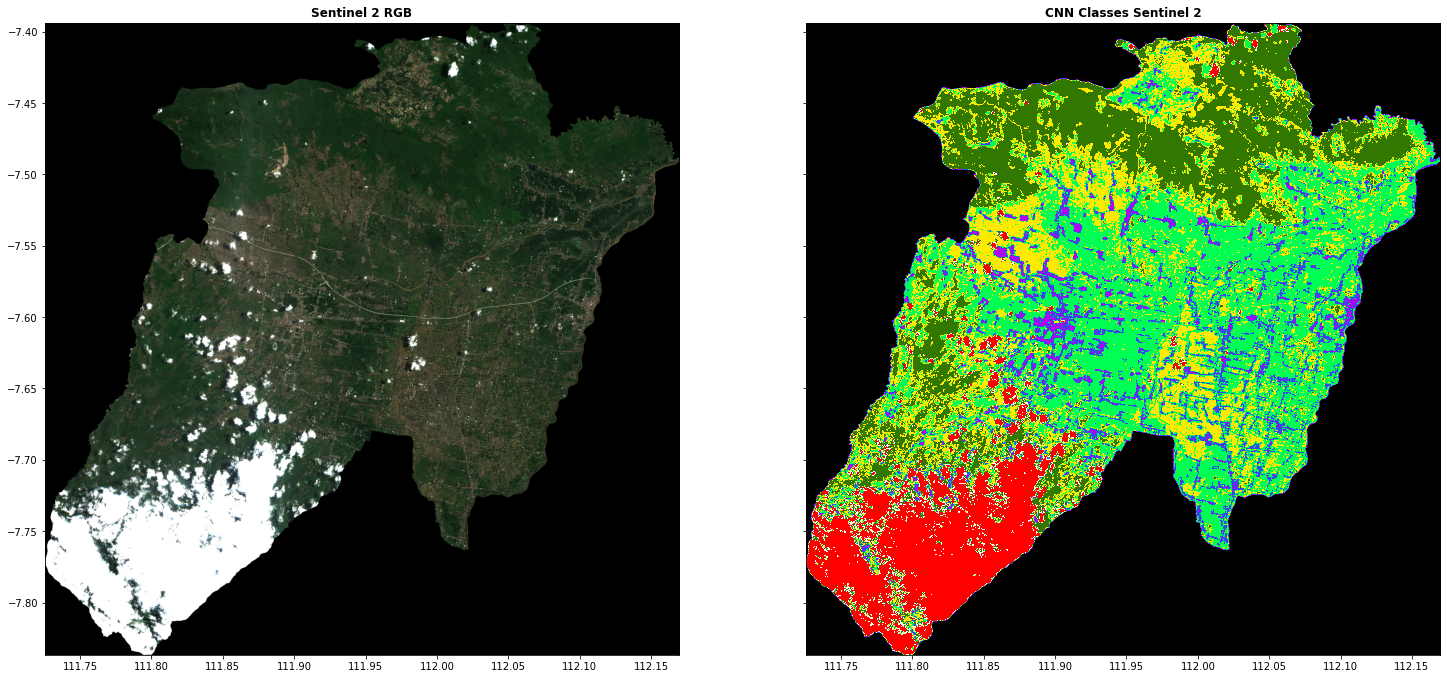

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(25, 25), sharey=True)

# show original image
show(s2_10[[2,1,0], : , :], transform=raster.transform, adjust='linear', ax=ax1, title="Sentinel 2 RGB")

# show predicted class
show(classes_sen, 
     transform=class_raster.transform, 
     ax=ax2, 
     title='CNN Classes Sentinel 2',
     cmap=cmap,
     norm=norm
     )

Count the number of pixel on each class

In [ ]:
file = output_image_sen_10

# Open the image and read in the values as an array
dataset = gdal.Open(file)
band = dataset.GetRasterBand(1)
Cols = dataset.RasterXSize
Rows = dataset.RasterYSize
arr = band.ReadAsArray(0, 0, Cols, Rows).astype(np.float)

# subset the array to only contain classification values equal to ...
class0 = arr[arr==0]
class1 = arr[arr==1]
class2 = arr[arr==2]
class3 = arr[arr==3]
class4 = arr[arr==4]
class5 = arr[arr==5]
class6 = arr[arr==6]
class7 = arr[arr==7]

print(len(class0))
print(len(class1))
print(len(class2))
print(len(class3))
print(len(class4))
print(len(class5))
print(len(class6))
print(len(class7))